In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report , accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [90]:
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline
plt.style.use("ggplot")

### 1. Import data

In [91]:
data = pd.read_csv("data/hotel_bookings.csv")
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015/7/1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015/7/1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015/7/2
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015/7/2
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015/7/3


In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [93]:
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### 2. Data cleaning

#### 2.1 Missing data processing

In [94]:
print("The proportion of missing data")
data.isnull().sum()[data.isnull().sum()!=0]/data.shape[0]

The proportion of missing data


children    0.000034
country     0.004087
agent       0.136862
company     0.943069
dtype: float64

In [95]:
data["agent"].unique()

array([ nan, 304., 240., 303.,  15., 241.,   8., 250., 115.,   5., 175.,
       134., 156., 243., 242.,   3., 105.,  40., 147., 306., 184.,  96.,
         2., 127.,  95., 146.,   9., 177.,   6., 143., 244., 149., 167.,
       300., 171., 305.,  67., 196., 152., 142., 261., 104.,  36.,  26.,
        29., 258., 110.,  71., 181.,  88., 251., 275.,  69., 248., 208.,
       256., 314., 126., 281., 273., 253., 185., 330., 334., 328., 326.,
       321., 324., 313.,  38., 155.,  68., 335., 308., 332.,  94., 348.,
       310., 339., 375.,  66., 327., 387., 298.,  91., 245., 385., 257.,
       393., 168., 405., 249., 315.,  75., 128., 307.,  11., 436.,   1.,
       201., 183., 223., 368., 336., 291., 464., 411., 481.,  10., 154.,
       468., 410., 390., 440., 495., 492., 493., 434.,  57., 531., 420.,
       483., 526., 472., 429.,  16., 446.,  34.,  78., 139., 252., 270.,
        47., 114., 301., 193., 182., 135., 350., 195., 352., 355., 159.,
       363., 384., 360., 331., 367.,  64., 406., 16

In [96]:
# children: delete missing rows
data.dropna(subset=["children"], inplace=True)
# country: delete missing rows
data.dropna(subset=["country"], inplace=True)
# company: delete column
data.drop(["company", "agent"], axis=1, inplace=True)

In [97]:
data.isnull().sum()[data.isnull().sum()!=0].count()

0

#### 2.2 Processing repeated rows

In [98]:
# check repeated rows
data.duplicated().sum()

31984

In [99]:
#remove repeated rows
data.drop_duplicates(inplace=True)
# check that removing is done
data.duplicated().sum()

0

#### 2.3 Outlier processing

In [100]:
numeric_features = data.select_dtypes(include=["int64","float64"]).columns
categorical_features = data.select_dtypes(include=["object"]).columns
print(numeric_features)
print("================================================")
print(categorical_features)

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')
Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status',
       'reservation_status_date'],
      dtype='object')


In [101]:
data.describe(include="object")

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date
count,86914,86914,86914,86914,86914,86914,86914,86914,86914,86914,86914,86914
unique,2,12,5,177,7,5,10,12,3,4,3,926
top,City Hotel,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,2016/2/14
freq,53404,11229,67540,27436,51534,69010,56166,46131,85770,71554,62931,210


In [102]:
for col in categorical_features:
    if col != "reservation_status_date":
        print(f"{col}: \n{data[col].unique()}\n")

hotel: 
['Resort Hotel' 'City Hotel']

arrival_date_month: 
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal: 
['BB' 'FB' 'HB' 'SC' 'Undefined']

country: 
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'OMN' 'ARG' 'POL' 'DEU'
 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST' 'CZE'
 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR' 'UKR'
 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO' 'ISR'
 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM' 'HRV'
 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY' 'KWT'
 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN' 'SYC'
 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB' 'CMR'
 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI' 'SAU'
 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB' 'NPL'
 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'E

In [103]:
data.meal.replace("Undefined", "SC", inplace=True)

In [104]:
data.drop(data[data["distribution_channel"]=="Undefined"].index, inplace=True)

In [105]:
data.drop(data[data["stays_in_weekend_nights"]+data["stays_in_week_nights"]==0].index, inplace=True)

In [106]:
data.drop(data[data["adults"]+data["children"]+data["babies"]==0].index, inplace=True)

In [107]:
data['is_canceled'].unique()

array([0, 1], dtype=int64)

In [108]:
# Canceled=1, Not canceled= 0
data['is_canceled'].value_counts()

0    62217
1    23949
Name: is_canceled, dtype: int64

### 3. Data analysis and visualization

#### target column

In [109]:
def map_iscanceld_values(df):
    return df["is_canceled"].map({0:"not canceled",1:"canceled"})

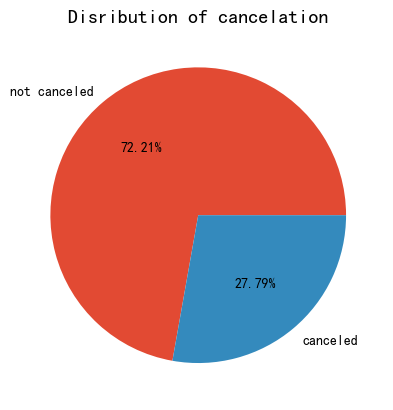

In [110]:
plt.pie(data.groupby(by=["is_canceled"]).size(), labels=map_iscanceld_values(data).unique(), autopct="%0.2f%%")
plt.title("Disribution of cancelation")
plt.show()

#### 3.1 Distribution of numerical columns

In [111]:
def draw_plot(data, val, rows, cols):
    fig, axes = plt.subplots(nrows=rows, ncols=cols)
    aux = 0
    fig.set_figwidth(25)
    fig.set_figheight(20)
    for row in axes:
        for col in row:
            if aux < len(val):
                sns.histplot(data, x=val[aux], ax=col)
                aux+=1

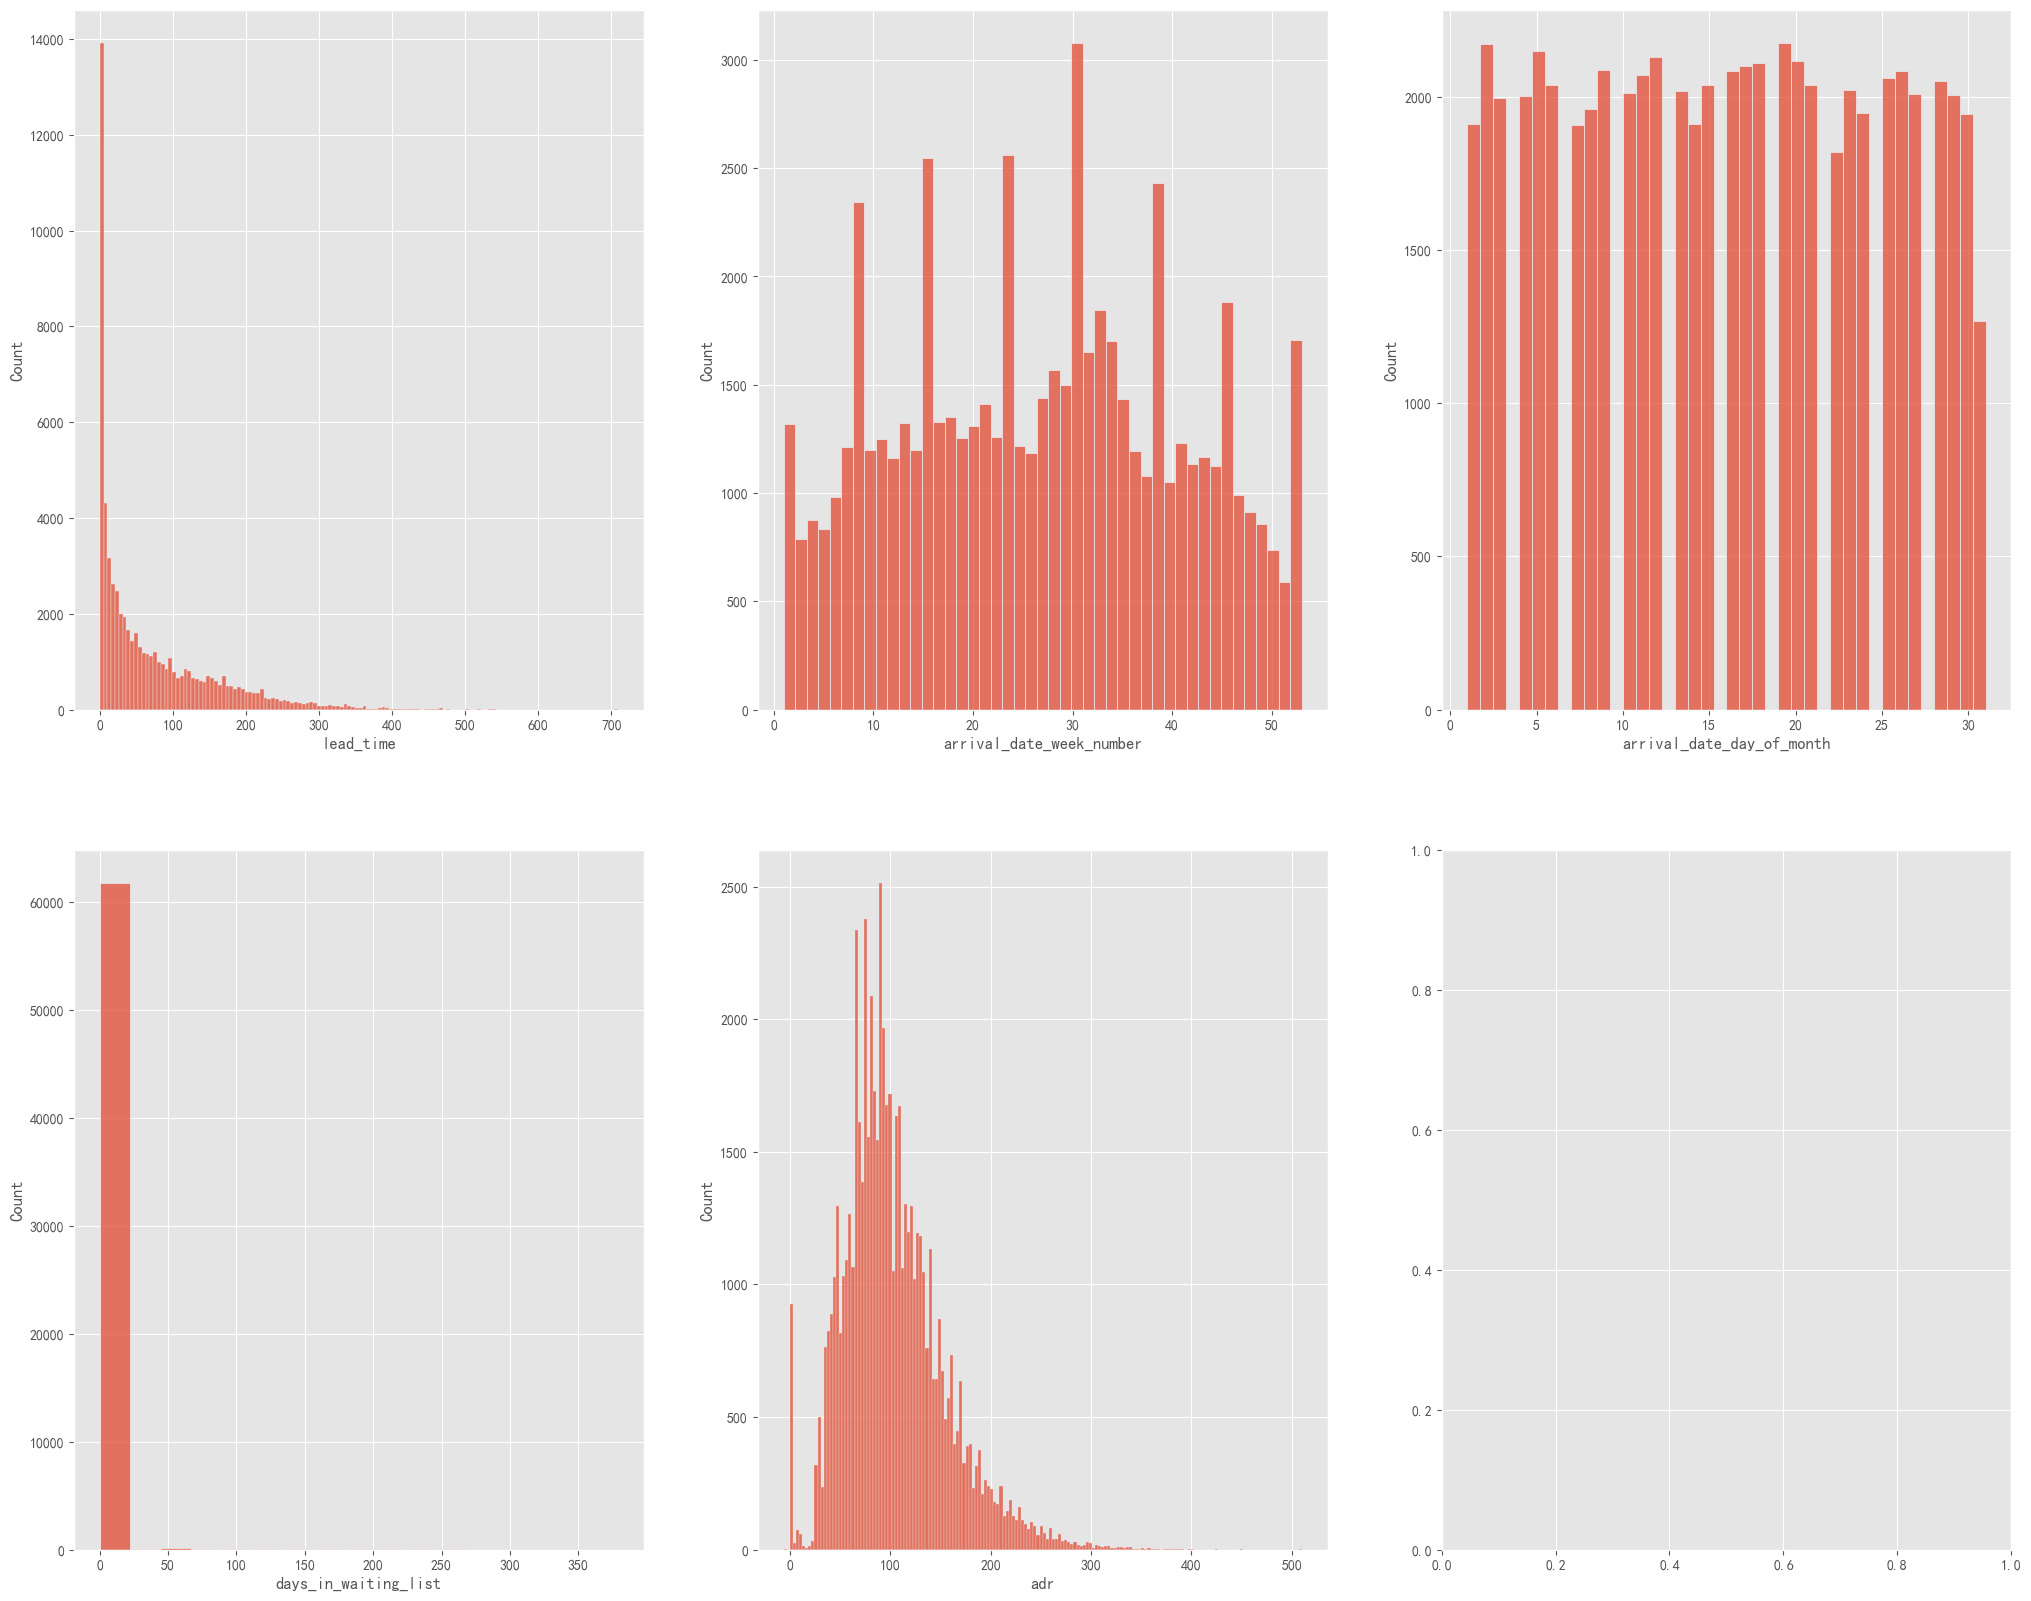

In [112]:
show_features = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month",
                "days_in_waiting_list", "adr"]
# 0: not canceled
df_lead_time_0 = data[data["is_canceled"]==0][show_features]
# show df_lead_time_0
draw_plot(df_lead_time_0, show_features, 2, 3);

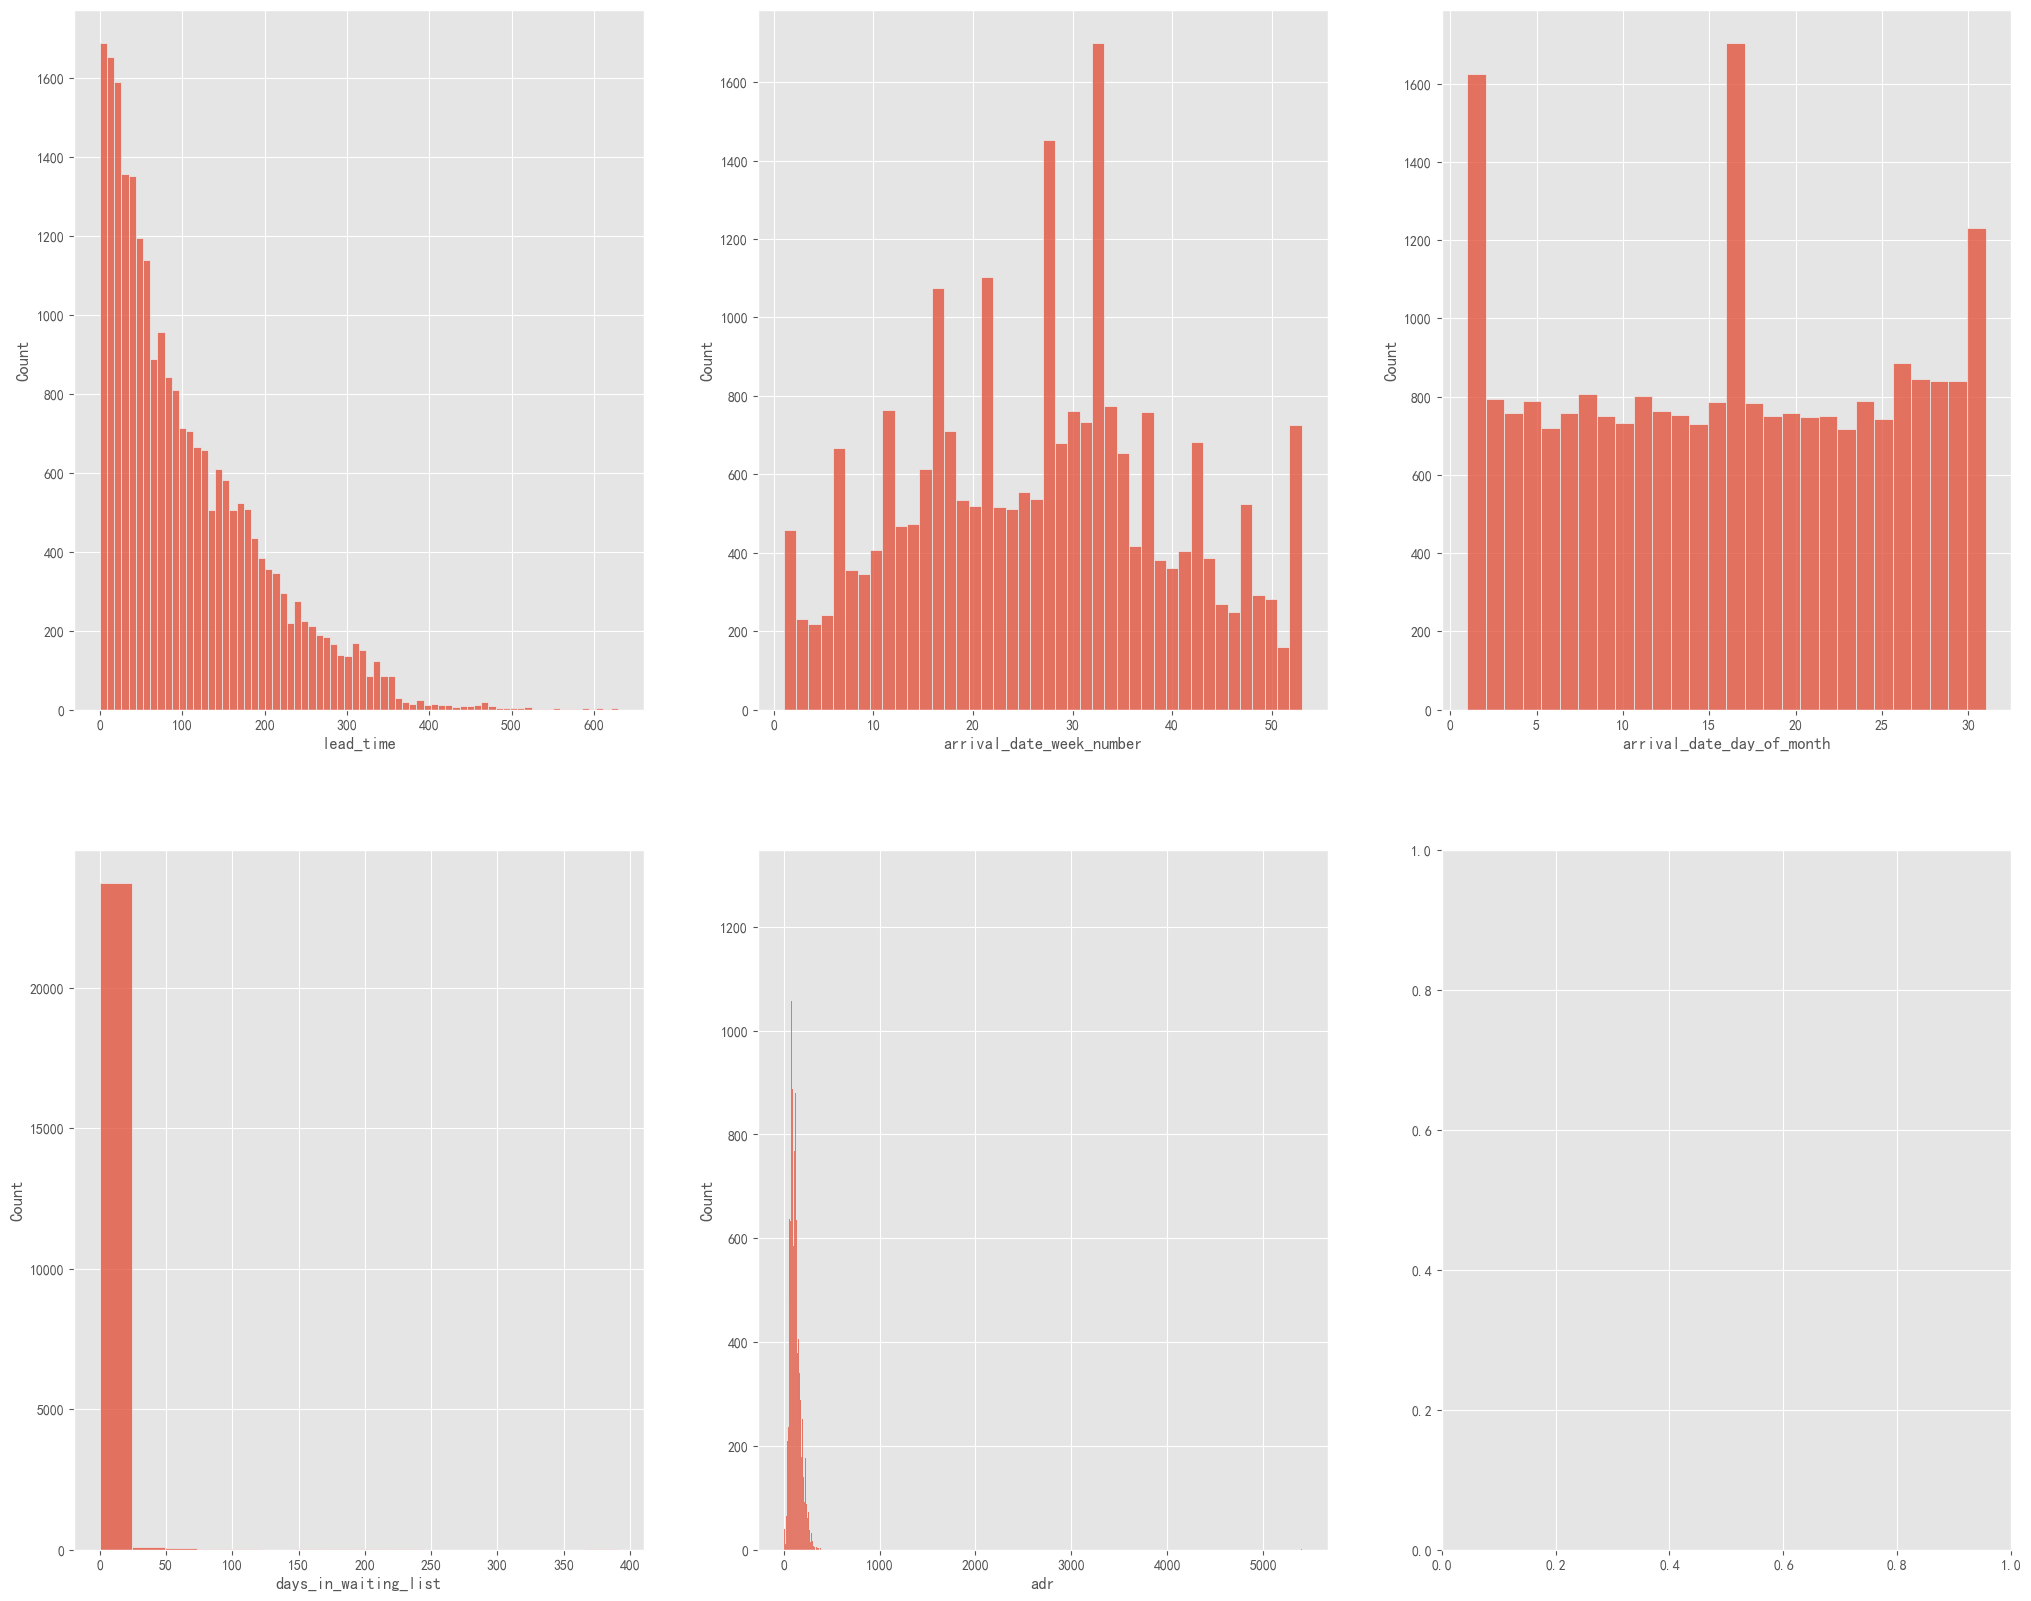

In [113]:
# 0: not canceled
df_lead_time_1 = data[data["is_canceled"]==1][show_features]
# show df_lead_time_1
draw_plot(df_lead_time_1, show_features, 2, 3)

In [114]:
def draw_countplot(df, x_val, hue_val, title):
    fig, ax = plt.subplots(figsize=(10,8))
    if type(hue_val) is str and hue_val == "":
        sns.countplot(data=df, x=x_val)
        ax.bar_label(ax.containers[0], fontsize=10)
    else:
        sns.countplot(data=df, x=x_val, hue=hue_val)
        ax.bar_label(ax.containers[0], fontsize=10)
        ax.bar_label(ax.containers[1], fontsize=10)
    ax.set_title(title, fontsize=15);

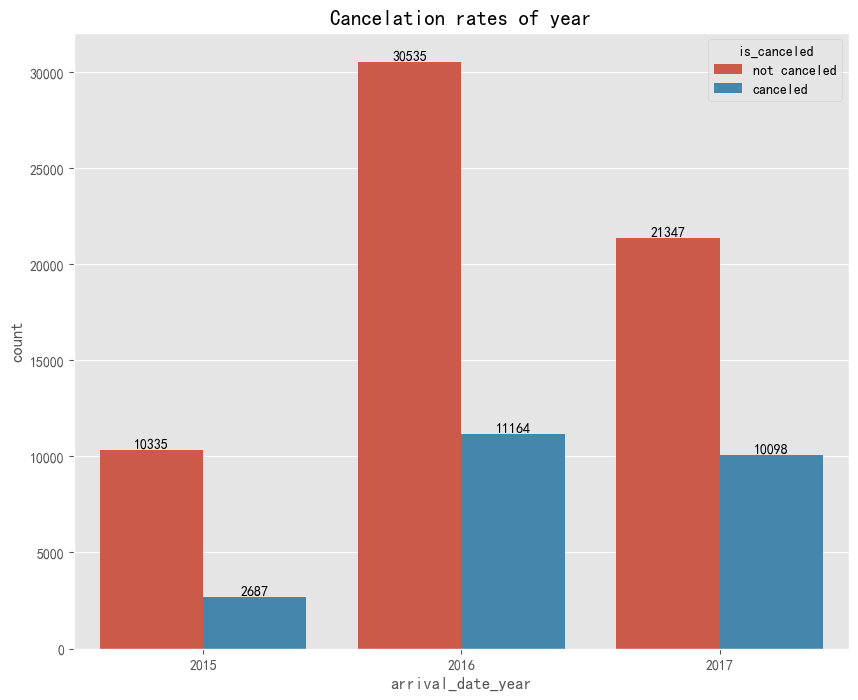

In [115]:
draw_countplot(data, "arrival_date_year", map_iscanceld_values(data), "Cancelation rates of year")

In [116]:
data.drop_duplicates(['arrival_date_year','arrival_date_month'])[["arrival_date_year","arrival_date_month"]]

,arrival_date_year,arrival_date_month
2,2015,July
842,2015,August
1485,2015,September
2087,2015,October
2835,2015,November
3272,2015,December
3738,2016,January
3864,2016,February
4275,2016,March
4803,2016,April


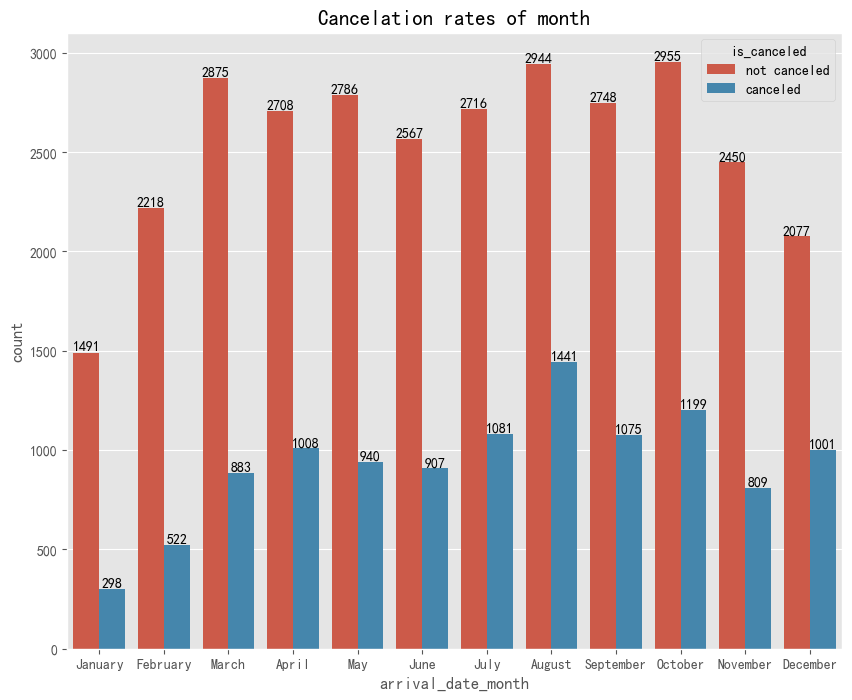

In [117]:
# Perform monthly analysis using 2016 data
data_2016 = data[data["arrival_date_year"]==2016]
draw_countplot(data_2016, "arrival_date_month", map_iscanceld_values(data_2016), "Cancelation rates of month")

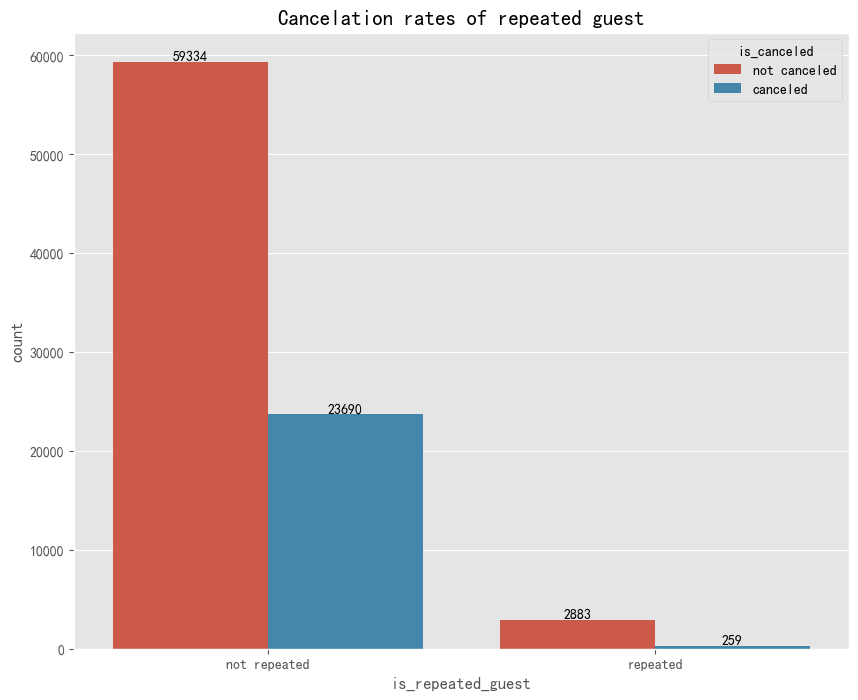

In [118]:
# print(data.groupby(["is_repeated_guest"])["is_canceled"].value_counts())
draw_countplot(data, data["is_repeated_guest"].map({0:"not repeated", 1:"repeated"}), map_iscanceld_values(data), "Cancelation rates of repeated guest")

#### 3.2 Distribution of category columns 

In [119]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

In [120]:
df_country = data["country"].value_counts().reset_index()
df_country.head(10)

,index,country
0,PRT,26846
1,GBR,10399
2,FRA,8813
3,ESP,7226
4,DEU,5383
5,ITA,3055
6,IRL,3014
7,BEL,2078
8,BRA,1986
9,NLD,1908


In [121]:
df_country = world.merge(df_country, how="left", left_on=["iso_a3"], right_on=["index"])
df_country.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,index,country
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",FJI,1.0
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",TZA,4.0
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",NaN,NaN
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",USA,1867.0


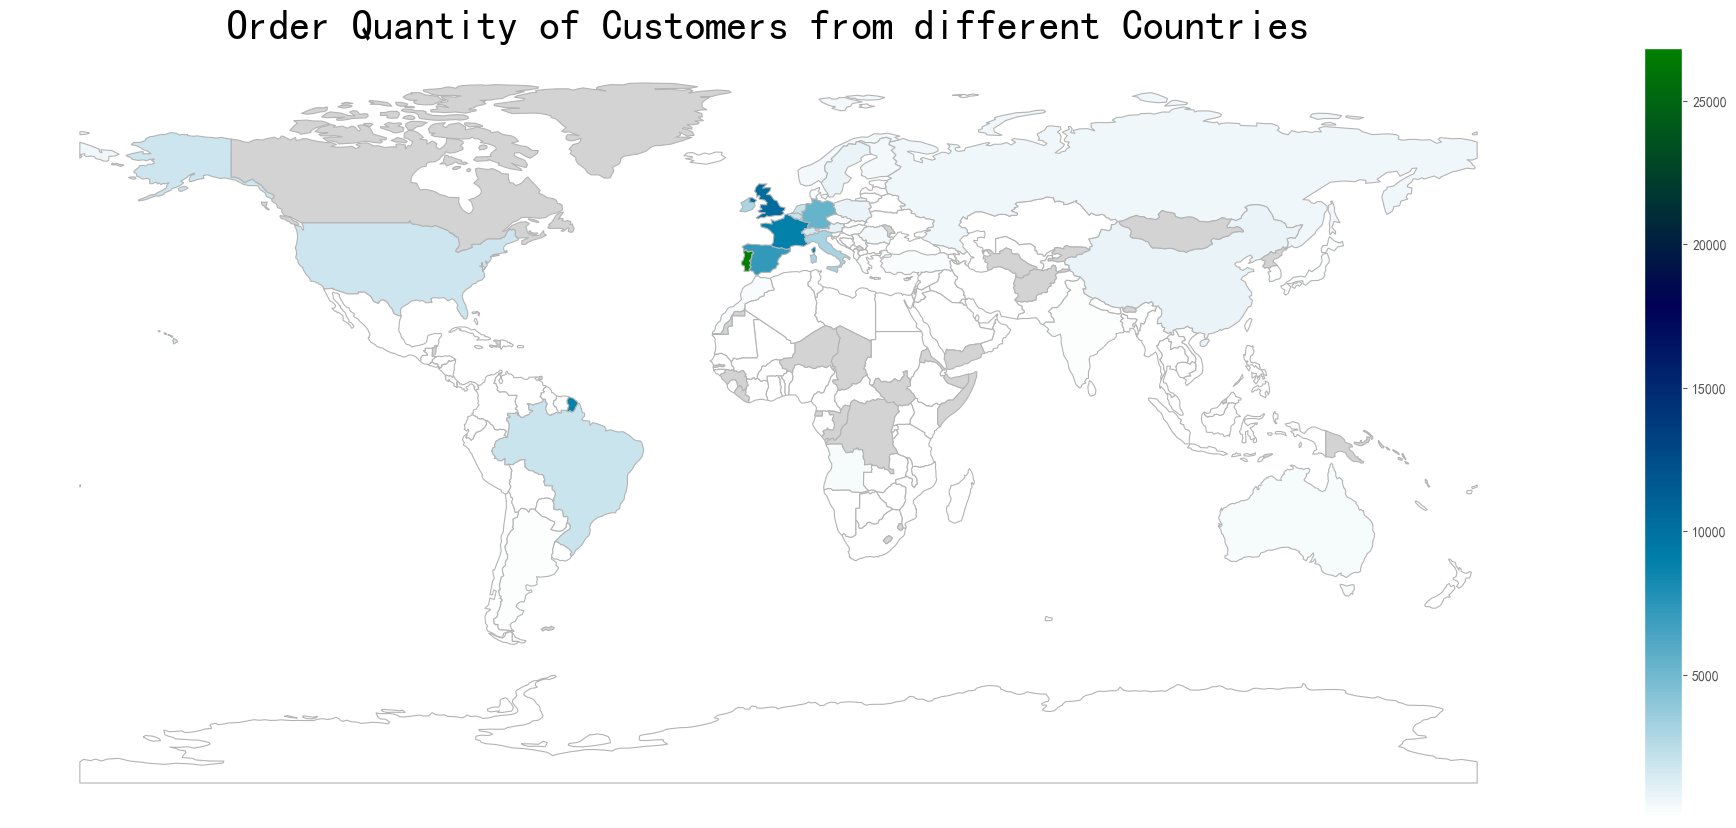

In [122]:
fig, ax = plt.subplots(1, figsize=(25,10))
df_country.plot(column="country", cmap="ocean_r", linewidth=0.8, ax=ax, edgecolors="0.7",legend=True,\
                missing_kwds={"color": "lightgrey"})
ax.set_title("Order Quantity of Customers from different Countries ", fontdict={"fontsize":30})
ax.set_axis_off()

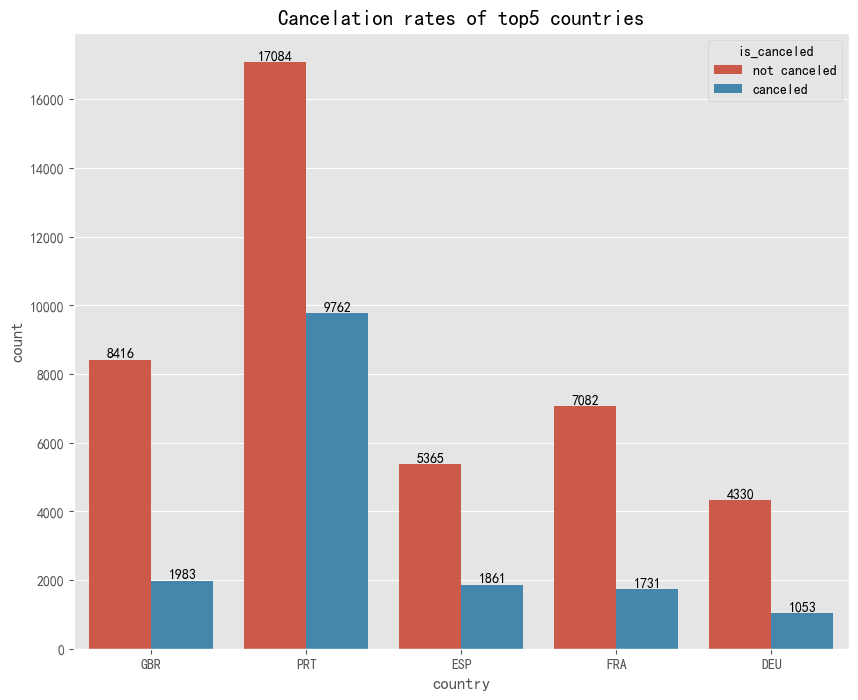

In [123]:
df_country_top5 = data[data["country"].isin(data["country"].value_counts()[:5].index)]
# print(df_country_top5.groupby(["country"])["is_canceled"].value_counts())
draw_countplot(df_country_top5, "country", map_iscanceld_values(df_country_top5), "Cancelation rates of top5 countries")

conclusion: from the chart above, we can see that hotel orders mainly come from new customers.

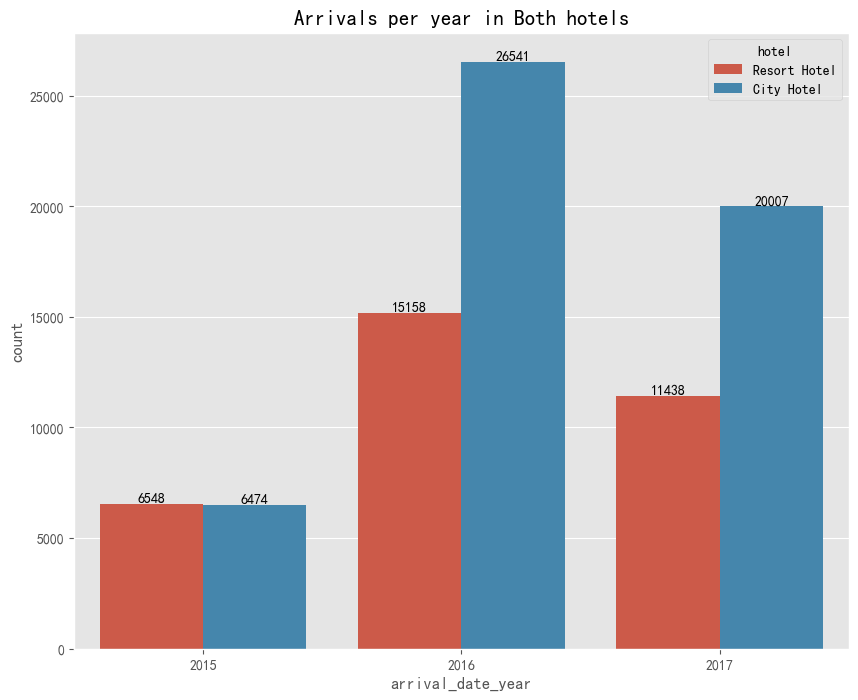

In [124]:
# print(data.groupby("arrival_date_year")["hotel"].value_counts())
draw_countplot(data, "arrival_date_year", "hotel", "Arrivals per year in Both hotels")

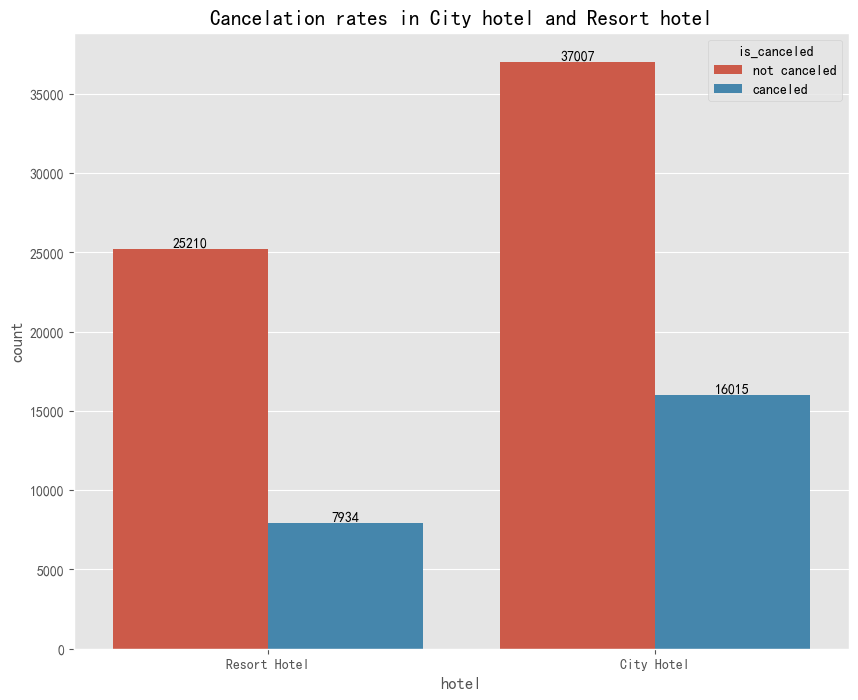

In [125]:
# print(data.groupby("hotel")["is_canceled"].value_counts())
draw_countplot(data, "hotel", map_iscanceld_values(data), "Cancelation rates in City hotel and Resort hotel")

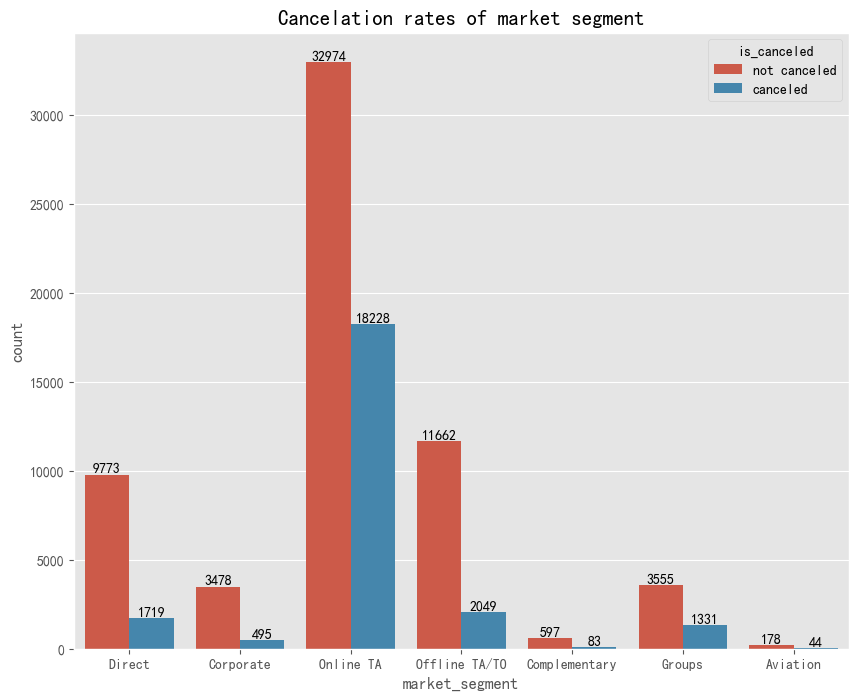

In [126]:
draw_countplot(data, "market_segment", map_iscanceld_values(data), "Cancelation rates of market segment")

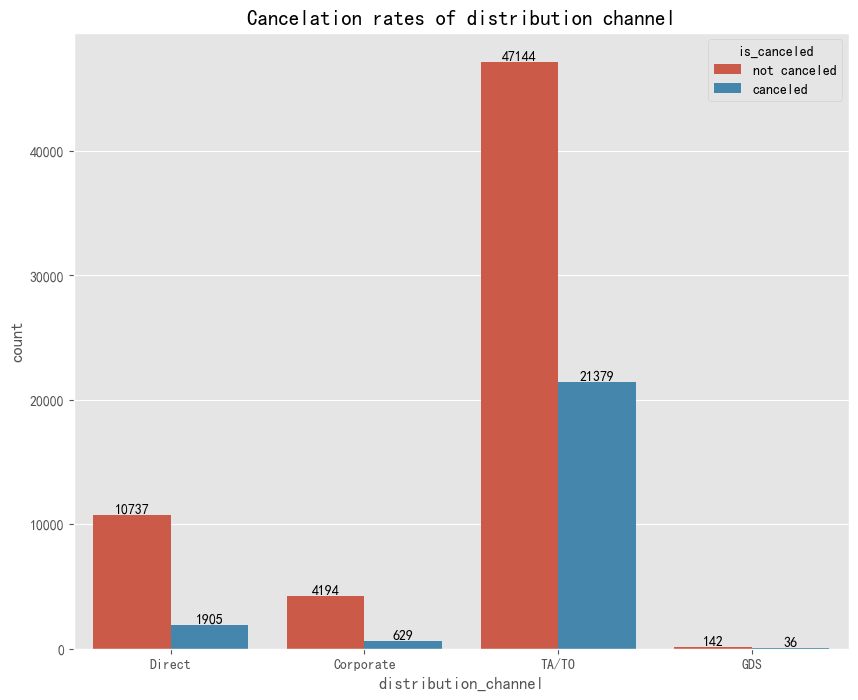

In [127]:
draw_countplot(data, "distribution_channel", map_iscanceld_values(data), "Cancelation rates of distribution channel")

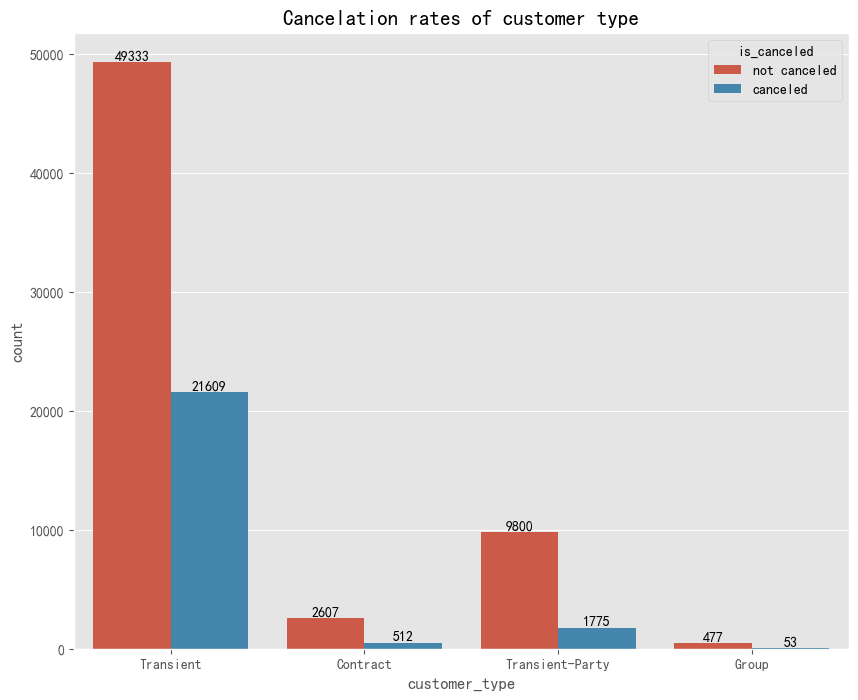

In [128]:
# print(data.groupby("customer_type")["is_canceled"].value_counts())
draw_countplot(data, "customer_type", map_iscanceld_values(data), "Cancelation rates of customer type")

conclusion: from the chart above, we can see that hotel orders mainly come from transient customers, which is higher than other type of customers.

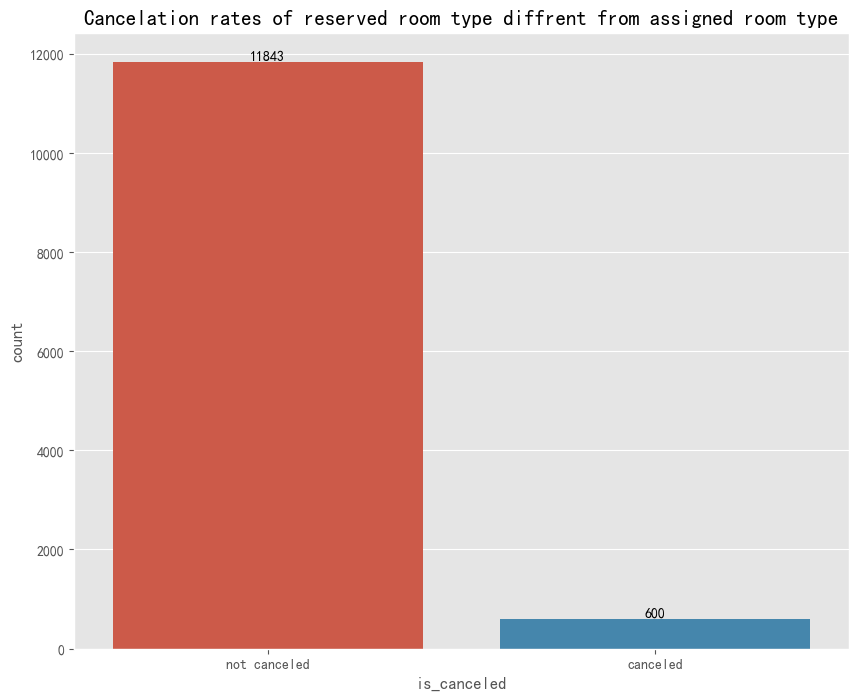

In [129]:
df_room_type = data[data["reserved_room_type"]!=data["assigned_room_type"]]
draw_countplot(df_room_type, map_iscanceld_values(df_room_type), "", "Cancelation rates of reserved room type diffrent from assigned room type")

conclusion: from the chart above, we can see that the difference between reserved room type and assigned room type has no impact on the cancellation of the order.

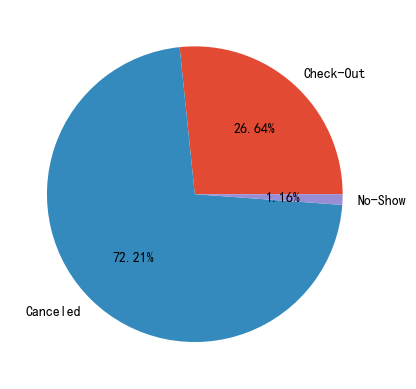

In [130]:
plt.pie(data.groupby(["reservation_status"]).size(), labels=data["reservation_status"].unique(), autopct="%0.2f%%")
plt.show()

### 3. Model Building

In [131]:
selected_features = ['arrival_date_week_number', 'arrival_date_day_of_month', 'adr','arrival_date_year', 'is_repeated_guest', 'hotel','country', 'market_segment','arrival_date_month',
       'distribution_channel','customer_type','reservation_status']
X = data[selected_features]
y = data["is_canceled"]

In [132]:
X["hotel"] = X["hotel"].factorize()[0]
X["country"] = X["country"].factorize()[0]
X["market_segment"] = X["market_segment"].factorize()[0]
X["arrival_date_month"] = X["arrival_date_month"].factorize()[0]
X["distribution_channel"] = X["distribution_channel"].factorize()[0]
X["customer_type"] = X["customer_type"].factorize()[0]
X["reservation_status"] = X["reservation_status"].factorize()[0]

In [133]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

In [134]:
def print_evaluate(model, X_test):
    pred = model.predict(X_test)
    print("accuracy score is {0}:".format(accuracy_score(y_test , pred)))
    print("classification report")
    print(classification_report(y_test , pred))

#### Random Forest

In [135]:
RF_model = RandomForestClassifier(n_estimators=100)
RF_model.fit(X_train , y_train)

RandomForestClassifier()

In [136]:
RF_model.score(X_train , y_train)

1.0

In [137]:
print_evaluate(RF_model, X_test)


accuracy score is 1.0:
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12445
           1       1.00      1.00      1.00      4789

    accuracy                           1.00     17234
   macro avg       1.00      1.00      1.00     17234
weighted avg       1.00      1.00      1.00     17234



#### Decision Tree

In [138]:
DT_model = DecisionTreeClassifier(random_state=42)
DT_model.fit(X_train , y_train)

DecisionTreeClassifier(random_state=42)

In [139]:
DT_model.score(X_test , y_test)

1.0

In [140]:
print_evaluate(DT_model, X_test)

accuracy score is 1.0:
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12445
           1       1.00      1.00      1.00      4789

    accuracy                           1.00     17234
   macro avg       1.00      1.00      1.00     17234
weighted avg       1.00      1.00      1.00     17234

